This notebook is modified from [the colab notebook](https://colab.research.google.com/drive/1GDb-lgeK06NHEr5uWbpsqrP19j5p7cpY?usp=sharing) used in [reproducing “Rainfall–runoff modelling using Long Short-Term Memory (LSTM) networks”](https://medium.com/@pietertolsma/reproducing-rainfall-runoff-modelling-using-long-short-term-memory-lstm-networks-991e883471ca) by Kratzert et al. (2019).

Reference:

Kratzert, F., Klotz, D., Herrnegger, M., Sampson, A.K., Hochreiter, S. and Nearing, G.S., 2019. Toward improved predictions in ungauged basins: Exploiting the power of machine learning. Water Resources Research, 55(12), pp.11344–11354.

# Load the python packagies

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


In [2]:
# Set the random seed to ensure reproducibility
torch.manual_seed(0);

# Load the atmospheric forcing and runoff data

The dataset is a processed Daymet product that averages the spatially distributed forcings/runoff belonging to catchment 13337000. See the details of the data processing in this [post](https://medium.com/@pietertolsma/reproducing-rainfall-runoff-modelling-using-long-short-term-memory-lstm-networks-991e883471ca).

In [3]:
# load entire dataset into pandas
df = pd.read_csv('./rain_runoff.csv', index_col='date',)

# drop empty column
df = df.drop(columns='Unnamed: 0.1')
df = df.drop(columns='Unnamed: 0')
df.head()


,prcp,tmax,tmin,vp,srad,runoff
date,,,,,,
1980-01-01,7.719036,2.635163,-7.404501,356.909575,108.665846,0.4296
1980-01-02,3.660781,2.484138,-7.616933,350.118484,123.689874,0.4560
1980-01-03,4.320509,0.016926,-5.137492,418.422967,74.293477,0.4720
1980-01-04,13.075693,-1.130720,-15.443935,194.276939,143.881449,0.4192
1980-01-05,15.739118,0.715120,-10.464246,281.074570,125.166372,0.4752


In [4]:
# convert -999 (no data) to 0
df['runoff'][df['runoff']==-999] = 0


/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_59224/4256306076.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['runoff'][df['runoff']==-999] = 0


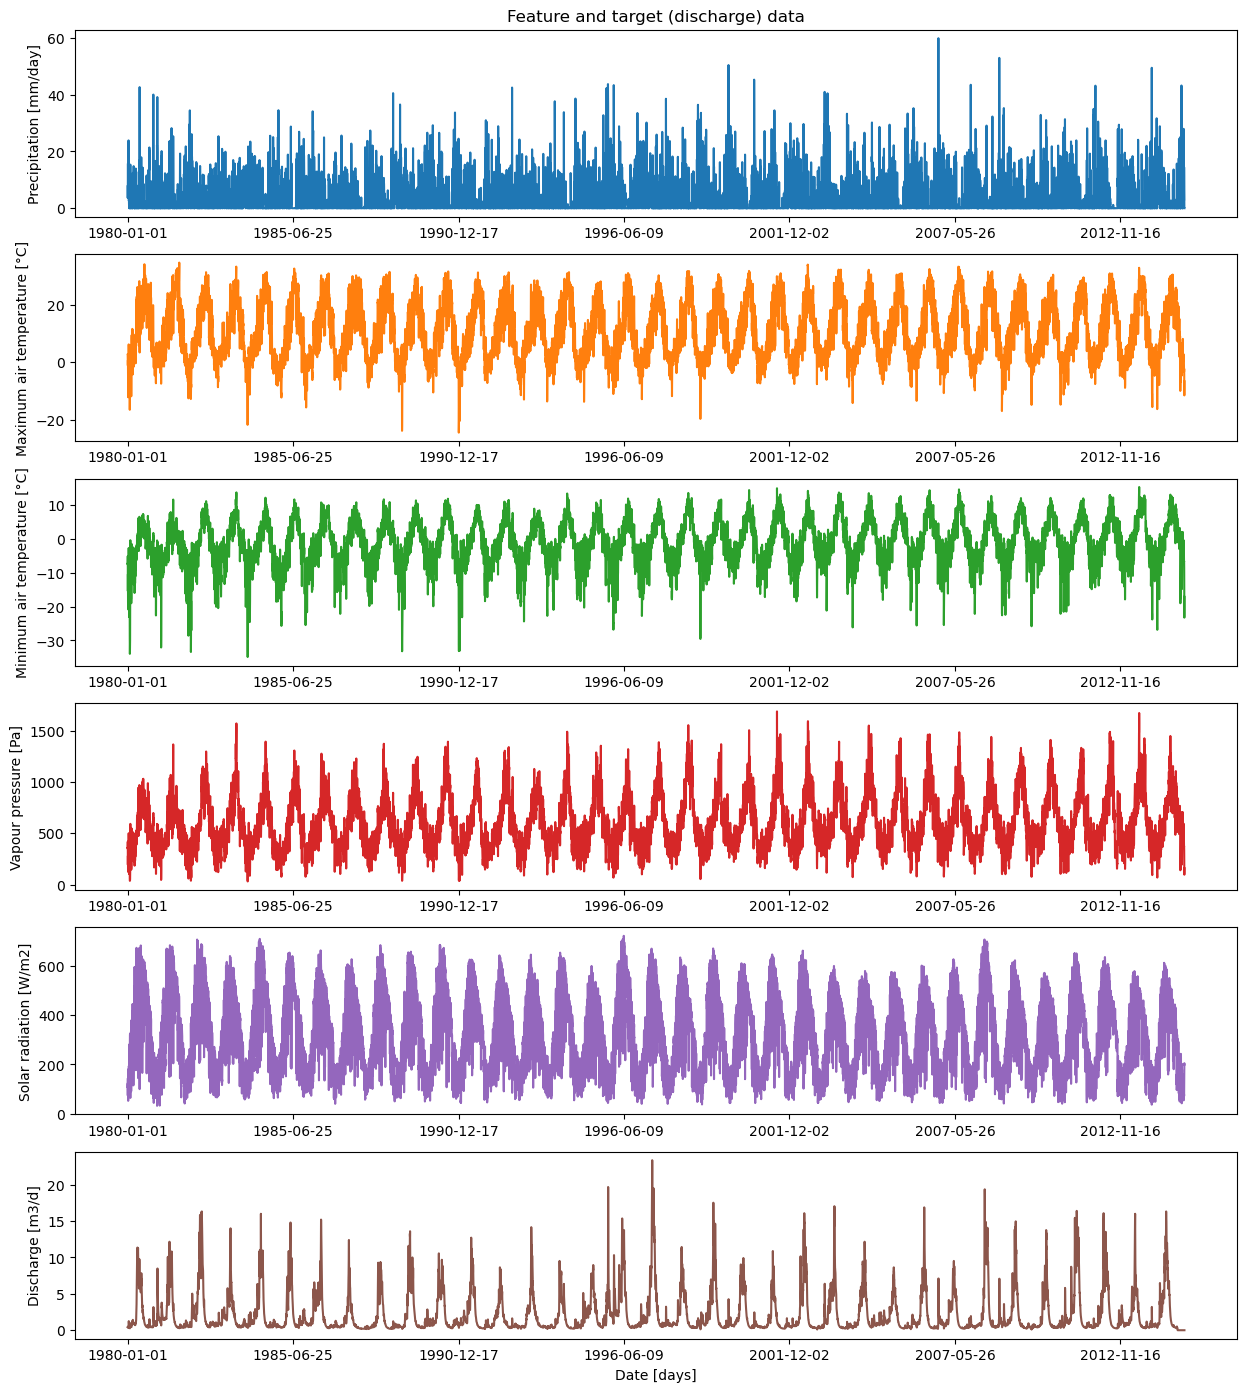

In [5]:
# Plot the time series
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(15,17))
df.plot(ax=ax,subplots=True);
y_labels = ['Precipitation [mm/day]', 'Maximum air temperature [°C]', 
            'Minimum air temperature [°C]', 'Vapour pressure [Pa]', 
            'Solar radiation [W/m2]', 'Discharge [m3/d]']
ax[0].set_title(f'Feature and target (discharge) data');
for i, iax in enumerate(ax):
    iax.set_ylabel(y_labels[i])
    iax.legend().remove()
    if iax is ax[-1]:
        iax.set_xlabel('Date [days]')
    else:
        iax.set_xlabel('')


# Data preprocessing

In this procedure, we first perform the data normalization/standardization and then divide the dataset into training and test data.

## Data normalization

In [6]:
 # ---------------------------------- Normalize the dataset ---------------------------------------
# P_mm: minmax, Tsoil/SWC/PAR: standard
scaler, df_norm = {}, df.copy()

for varn in df.columns:
    # if varn in ['prcp', 'vp', 'runoff', 'srad']:
    #     scaler_v = MinMaxScaler()
    # else:
        # scaler_v = StandardScaler()
    scaler_v = StandardScaler()
    df_norm[varn] = scaler_v.fit_transform(df[[varn]].values)
    scaler[varn] = scaler_v


In [7]:
df_norm.head()

,prcp,tmax,tmin,vp,srad,runoff
date,,,,,,
1980-01-01,0.712125,-0.795295,-0.883412,-0.898776,-1.322209,-0.607578
1980-01-02,0.006883,-0.810337,-0.914220,-0.924037,-1.227324,-0.598299
1980-01-03,0.121530,-1.056077,-0.554636,-0.669966,-1.539290,-0.592675
1980-01-04,1.643002,-1.170385,-2.049340,-1.503719,-1.099803,-0.611233
1980-01-05,2.105851,-0.986535,-1.327155,-1.180859,-1.217999,-0.591550


## Split the data into train and test sets

In [8]:
train_start = '1980-10-01' # starts 1 year later due to padding in figure
train_end = '1995-09-30'

test_start = '1995-10-01' # starts 1 year later due to padding in figure
test_end = '2000-09-30'


In [9]:
# divide dataset in training and test set
df_norm_train = df_norm.loc[train_start:train_end].copy()
df_norm_test = df_norm.loc[test_start:test_end].copy()

# print fraction the test set is of all the used data
print('Test set fraction: ', len(df_norm_test) / (len(df_norm_train) + len(df_norm_test)))


Test set fraction:  0.2501369863013699


# Rainfall-Runoff modeling

## Configuration

In [16]:
# Model output variable
target   = 'runoff'

# Model input feature
features = list(df_norm.columns.difference([target]))

# DL model configuration and training settings
sequence_length = 365
batch_size =  512
learning_rate = 0.1
num_hidden_units = 20
epochs = 50
device='cpu'
# epochs = 50
# device='cuda:0'

# An boolean indicator showing whether the DL training finishes
training_complete = False


## Create a pytorch custom dataset

The pytorch dataset is used by pytorch dataloader during the DL model training. A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. 
- The __init__ function is run once when instantiating the Dataset object. 
- The __len__ function returns the number of samples in our dataset.
- The __getitem__ function loads and returns a sample from the dataset at the given index i.

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):

        # save which are the features and target data and sequence length
        self.features = features
        self.target = target
        self.sequence_length = sequence_length

        # load data from dataframe into tensor
        y = torch.tensor(dataframe[self.target].values).float()
        X = torch.tensor(dataframe[self.features].values).float()

        # remove padding from data and save data in class
        self.y = y[sequence_length:]
        self.X = X[sequence_length:,:]

        # make extra dataseries for padding
        self.yPadding = y[:sequence_length*2]
        self.XPadding = X[:sequence_length*2,:]
        # self.sequence_length = sequence_length


    def __len__(self):

        # return length shape
        return self.X.shape[0]


    def __getitem__(self, i): 

        # select data from the dataset without padding and return data
        if i > self.sequence_length:
            Xr = self.X[i-self.sequence_length:i,:]
            yr = self.y[i-1]

            return Xr , yr
          
        # select from the padding dataset and return data
        else:
            Xr = self.XPadding[i:i+self.sequence_length,:]
            yr = self.yPadding[i+self.sequence_length - 1]

            return Xr, yr


In [12]:
# make train and test dataset
train_dataset = TimeSeriesDataset(df_norm_train,
                                  target=target,
                                  features=features,
                                  sequence_length=sequence_length)
test_dataset = TimeSeriesDataset(df_norm_test,
                                target=target,
                                features=features,
                                sequence_length=sequence_length)

# load dataset in DataLoader
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)
test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)
train_eval_loader = DataLoader(train_dataset, 
                               batch_size=batch_size,  
                               shuffle=False)


## Define a LSTM model
The LSTM model has two LSTM layers with a dropout layer in between. 

In [13]:
class LSTM(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()

        # save needed info to initialize layers
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = 1

        # first LSTM layer of model
        self.lstm1 = nn.LSTM(input_size=num_features,
                             hidden_size=hidden_units,
                             batch_first=True,
                             num_layers=self.num_layers)

        # second LSTM layer of model
        self.lstm2 = nn.LSTM(input_size=hidden_units,
                             hidden_size=hidden_units,
                             batch_first=True,
                             num_layers=self.num_layers)

        # dropout layer
        self.dropout = nn.Dropout(p=0.1)

        # linear layer
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def lstm_only(self, x):
        batch_size = x.shape[0]

        # initialize c0 and h0
        c0 = torch.zeros(self.num_layers, batch_size,
                         self.hidden_units).requires_grad_()
        h0 = torch.zeros(self.num_layers, batch_size,
                         self.hidden_units).requires_grad_()

        # load data into layers as written in the paper and return the output
        # data
        x, (_, _) = self.lstm1(x, (h0, c0))
        x = self.dropout(x)
        h_all, (ht,ct) = self.lstm2(x, (h0, c0))
        return h_all, ht, ct

    def forward(self, x):
        _, ht, _ = self.lstm_only(x)
        out = self.linear(ht[0]).flatten()
        return out
    
    def output_all(self, x):
        h_all, ht, _ = self.lstm_only(x)
        out = self.linear(ht[0]).flatten()

        h_trans = torch.cat([self.linear(h_all[:,i,:]) for i in range(x.shape[1])], 1)
        # print(h_all.shape, h_trans.shape)

        return out, h_trans


In [14]:
# check if the features and targets are made accordingly with the right shapes
# and sizes(trust us, they are)
X, y = next(iter(train_loader))
print('Features shape:', X.shape)
print('Target shape:', y.shape)

# initialize model 
model = LSTM(num_features=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,)
model.to(device)
model

Features shape: torch.Size([512, 365, 5])
Target shape: torch.Size([512])


LSTM(
  (lstm1): LSTM(5, 20, batch_first=True)
  (lstm2): LSTM(20, 20, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=20, out_features=1, bias=True)
)

## Train the DL model

We first define some utility functions for the ease of the model development, including
- **train_model** for training the DL model
- **test_model** for evaluating the DL model
- **predict_model** for the model prediction

In [15]:
def train_model(data_loader, model, loss_function, optimizer, device='cpu'):

    # initialize variables
    num_batches = len(data_loader)
    total_loss = 0
    
    # iterate through data from dataloader and run model and calculate loss
    model.train()
    for X, y in data_loader:
        output = model(X.to(device))
        loss = loss_function(output, y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f'Train loss: {avg_loss}')
    
    return avg_loss


def test_model(data_loader, model, loss_function, device='cpu'):
    
    # initialize variables
    num_batches = len(data_loader)
    total_loss = 0

    # iterate through data from dataloader and test model and calculate loss
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X.to(device))
            total_loss += loss_function(output, y.to(device)).item()

    avg_loss = total_loss / num_batches
    print(f'Test loss: {avg_loss}')

    return avg_loss

def predict(data_loader, model, device='cpu'):
    
    # initiaze output data
    y_pred_set = torch.tensor([], device=device)
    ht_trans_set = torch.tensor([], device=device)

    # iterate through data from data loader and make prediction
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            # y_pred = model(X.to(device))
            # output = torch.cat((output, y_pred.to(device)), 0)
            y_pred, ht_trans = model.output_all(X.to(device))
            # print(ht_trans.shape, y_pred.shape)
            y_pred_set = torch.cat((y_pred_set, y_pred.to(device)), 0)
            ht_trans_set = torch.cat((ht_trans_set, torch.tensor(ht_trans).to(device)), 0)
    
    return y_pred_set, ht_trans_set


In [18]:
# train model and calculate training and test loss
train_loss_epochs = [i for i in range(1,epochs+1)]
test_loss_epochs = [i for i in range(1,epochs+1)]
train_losses, test_losses = [], []
for epoch_i in range(1,epochs+1):
    print('\n')
    print(f'Epoch {epoch_i}\n-----')

    # epoch
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer, device=device)
    test_loss = test_model(test_loader, model, loss_function, device=device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

training_complete = True



Epoch 1
-----
Train loss: 1.036622315645218
Test loss: 1.2729776899019878


Epoch 2
-----
Train loss: 0.6148284494876861
Test loss: 1.1067951321601868


Epoch 3
-----
Train loss: 0.47561667263507845
Test loss: 1.0730354487895966


Epoch 4
-----
Train loss: 0.2845563992857933
Test loss: 0.6033841818571091


Epoch 5
-----
Train loss: 0.2048032522201538
Test loss: 0.5001269342998663


Epoch 6
-----
Train loss: 0.18501825332641603
Test loss: 0.41905079782009125


Epoch 7
-----
Train loss: 0.16342734917998314
Test loss: 0.4330371903876464


Epoch 8
-----
Train loss: 0.15242550298571586
Test loss: 0.36847617973883945


Epoch 9
-----
Train loss: 0.14704902619123458
Test loss: 0.4338461086153984


Epoch 10
-----
Train loss: 0.2512020871043205
Test loss: 0.5427716622749964


Epoch 11
-----
Train loss: 0.15407955422997474
Test loss: 0.43569182852904004


Epoch 12
-----
Train loss: 0.13825802505016327
Test loss: 0.521229567627112


Epoch 13
-----
Train loss: 0.11482974961400032
Test loss: 0.349

## Plot the loss values over epochs

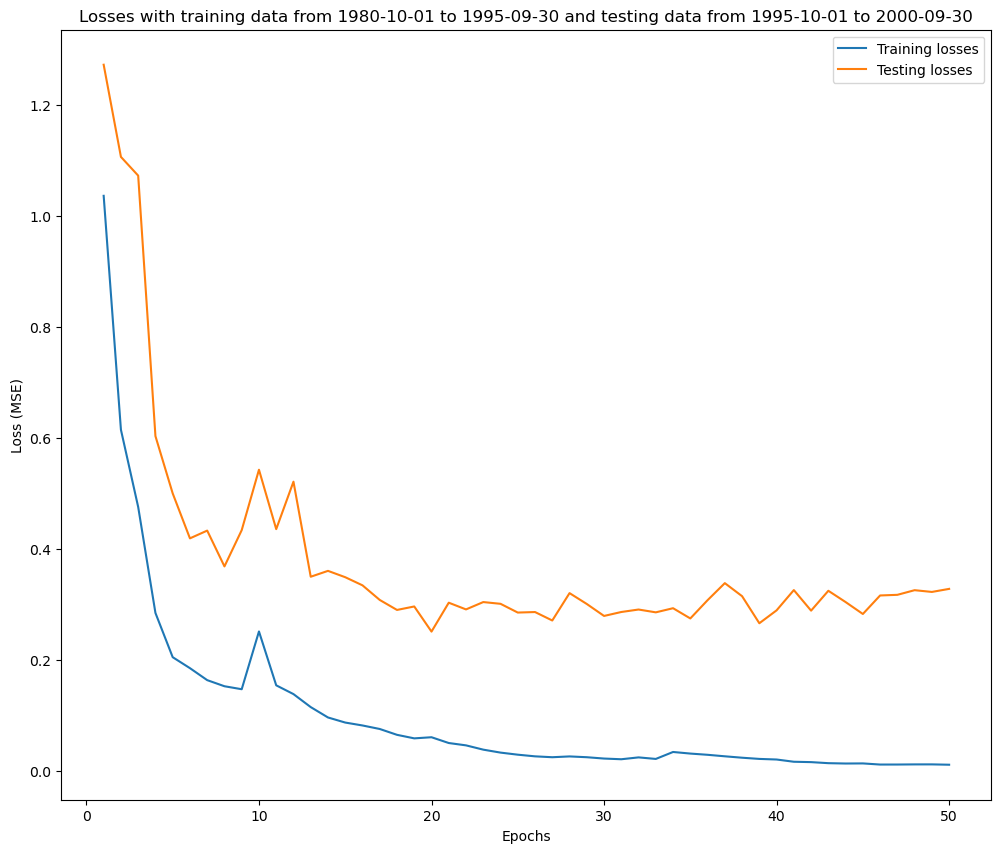

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(train_loss_epochs, train_losses, label='Training losses')
ax.plot(test_loss_epochs, test_losses, label='Testing losses')
ax.set(title=f'Losses with training data from {train_start} to {train_end} and testing data from {test_start} to {test_end}',
       ylabel='Loss (MSE)', xlabel='Epochs')
ax.legend(loc='upper right');


## Save the model or load the model
Load a pretrained model if the training is not complete.

In [21]:
# If the training is completed, save the model parameters
if training_complete:
    torch.save(model.state_dict(), 'model.pth')

# Or we load a pretrained model
else:
    model_weights_path = "model.pth"
    model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))
    model.eval()



## Use the trained model to make streamflow predictions

In [22]:
# predict data with model
y_pred_train, ht_trans_train = predict(train_eval_loader, model, device=device)
y_pred_test, ht_trans_test = predict(test_loader, model, device=device)

# make placeholder for model output data
y_pred_col = 'LSTM model discharge prediction'

# load data in dataframe
df_train_out = pd.DataFrame(index=df_norm_train.index[sequence_length:],
                            data={target:df_norm_train[target][sequence_length:],
                                  y_pred_col:y_pred_train})
df_train_h = pd.DataFrame(index=df_norm_train.index[sequence_length:],
                          data=ht_trans_train.numpy()[:,::-1])

df_test_out = pd.DataFrame(index=df_norm_test.index[sequence_length:],
                        data={target:df_norm_test[target][sequence_length:],
                              y_pred_col:y_pred_test})
df_test_h = pd.DataFrame(index=df_norm_test.index[sequence_length:],
                          data=ht_trans_test.numpy()[:,::-1])

# de-normalize data
for col in df_train_out.columns:
    df_train_out[col] = scaler[target].inverse_transform(df_train_out[[col]].values)

for col in df_test_out.columns:
    df_test_out[col] = scaler[target].inverse_transform(df_test_out[[col]].values)

# calculate RMSE for both datasets
RMSE_test = ((df_test_out[target] - df_test_out[y_pred_col]) ** 2).mean() ** .5
RMSE_train = ((df_train_out[target] - df_train_out[y_pred_col]) ** 2).mean() ** .5
CC_test  = np.corrcoef(df_test_out[target], df_test_out[y_pred_col])[0,1]
CC_train = np.corrcoef(df_train_out[target], df_train_out[y_pred_col])[0,1]


/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_59224/3913673441.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ht_trans_set = torch.cat((ht_trans_set, torch.tensor(ht_trans).to(device)), 0)


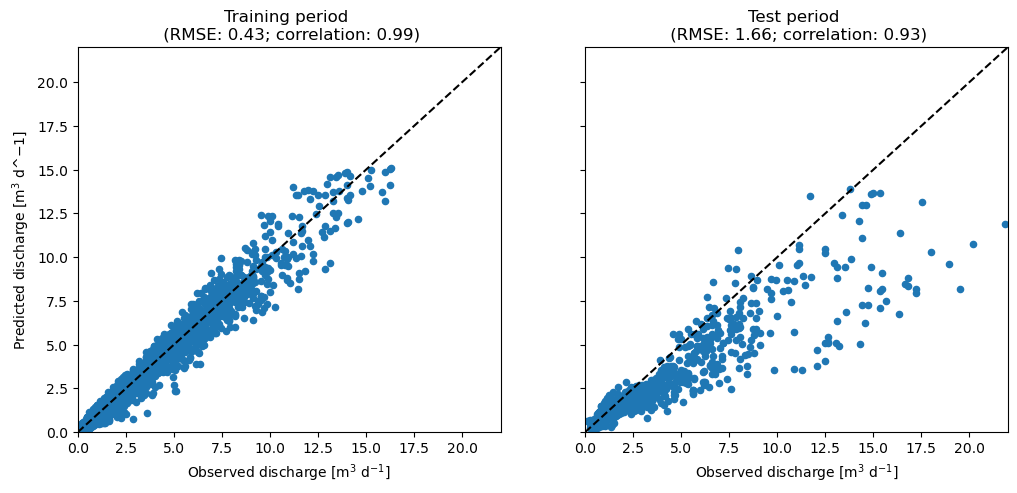

In [35]:
# Scatter plot
lim = [0,22]
fig, axes = plt.subplots(1,2,figsize=(12,5),sharex=True, sharey=True)

# Training period
ax = axes[0]
df_train_out.plot(x='runoff', y='LSTM model discharge prediction', kind='scatter', ax=ax)
ax.plot(lim, lim, 'k--')
ax.set(
    xlabel='Observed discharge [m$^3$ d$^{-1}$]', ylabel='Predicted discharge [m$^3$ d^${-1}$]',
    title='Training period \n (RMSE: {:.2f}; correlation: {:.2f})'.format(RMSE_train, CC_train),
    xlim=lim, ylim=lim
)

# Test period
ax = axes[1]
df_test_out.plot(x='runoff', y='LSTM model discharge prediction', kind='scatter', ax=ax)
ax.plot(lim, lim, 'k--')
ax.set(
    xlabel='Observed discharge [m$^3$ d$^{-1}$]', ylabel='Predicted discharge [m$^3$ d^${-1}$]', 
    title='Test period \n (RMSE: {:.2f}; correlation: {:.2f})'.format(RMSE_test, CC_test),
    xlim=lim, ylim=lim
);


/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_59224/884786684.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_59224/884786684.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


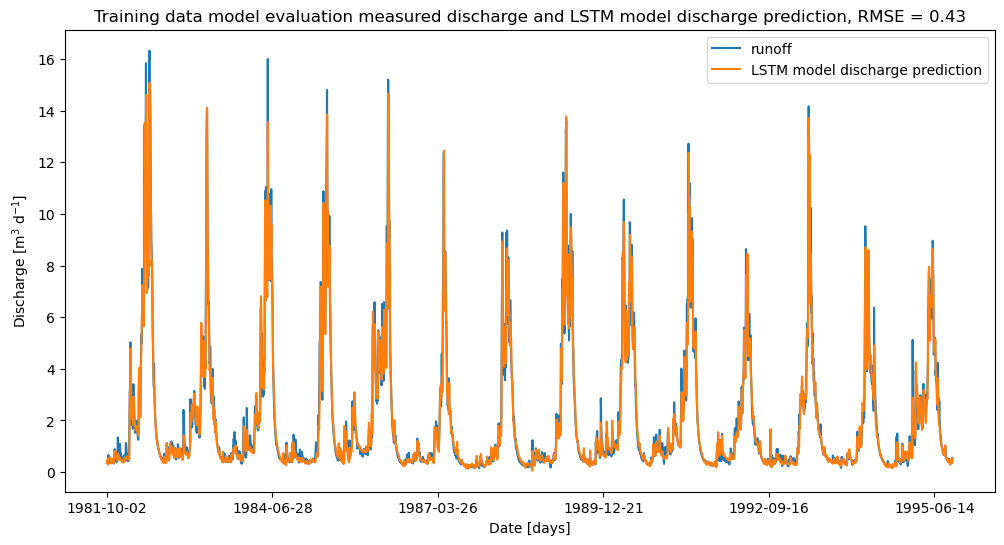

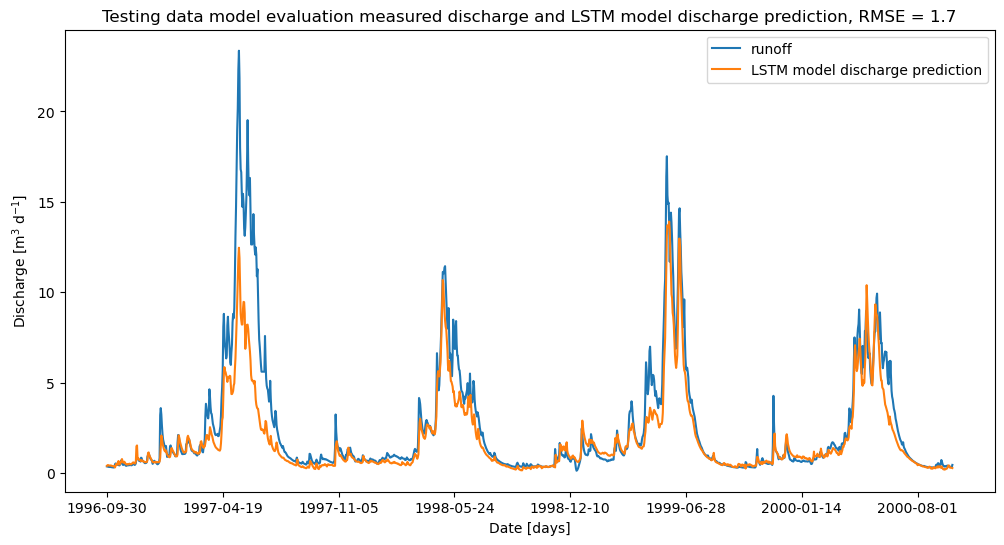

In [30]:
# plot
fig,ax = plt.subplots(figsize=(12,6))
df_train_out.plot(ax=ax)
ax.set_ylabel('Discharge [m$^3$ d$^{-1}$]');
ax.set_xlabel('Date [days]');
ax.set_title(f'Training data model evaluation measured discharge and LSTM model discharge prediction, RMSE = {RMSE_train:.2}');
fig.show()

# plot
fig,ax = plt.subplots(figsize=(12,6))
df_test_out.plot(ax=ax)
ax.set_ylabel('Discharge [m$^3$ d$^{-1}$]');
ax.set_xlabel('Date [days]');
ax.set_title(f'Testing data model evaluation measured discharge and LSTM model discharge prediction, RMSE = {RMSE_test:.2}');
fig.show()


## What did the hidden states learn?

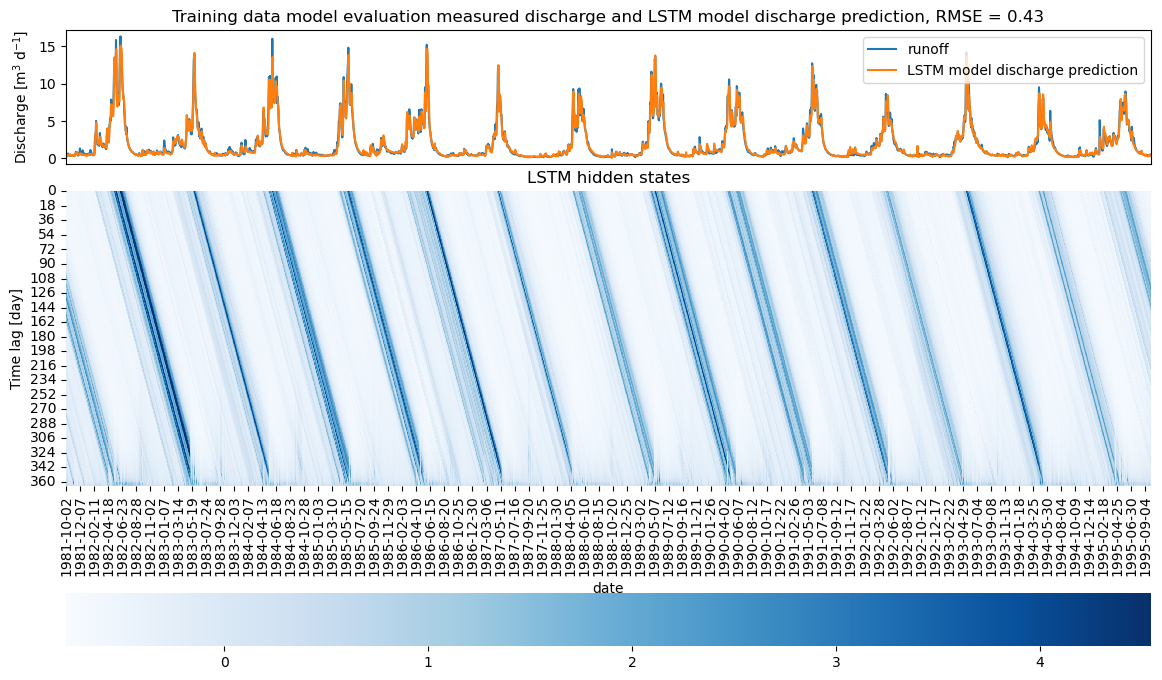

In [31]:
# Training period
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig,hspace=0.5)
ax1 = fig.add_subplot(gs[2:-2,:])
ax2, ax3 = fig.add_subplot(gs[-1,:]), fig.add_subplot(gs[:2,:])

ax1=sns.heatmap(
    df_train_h.T, cmap='Blues', ax=ax1, cbar_ax=ax2, 
    cbar_kws={'orientation':'horizontal', 'fraction':'0.07', 'anchor':(1,-0.5)}
)
ax1.set(title='LSTM hidden states', ylabel='Time lag [day]')
df_train_out.plot(ax=ax3)
ax3.set(ylabel='Discharge [m$^3$ d$^{-1}$]', xlabel='', xlim=ax1.get_xlim(), xticks=[],
        title=f'Training data model evaluation measured discharge and LSTM model discharge prediction, RMSE = {RMSE_train:.2}');


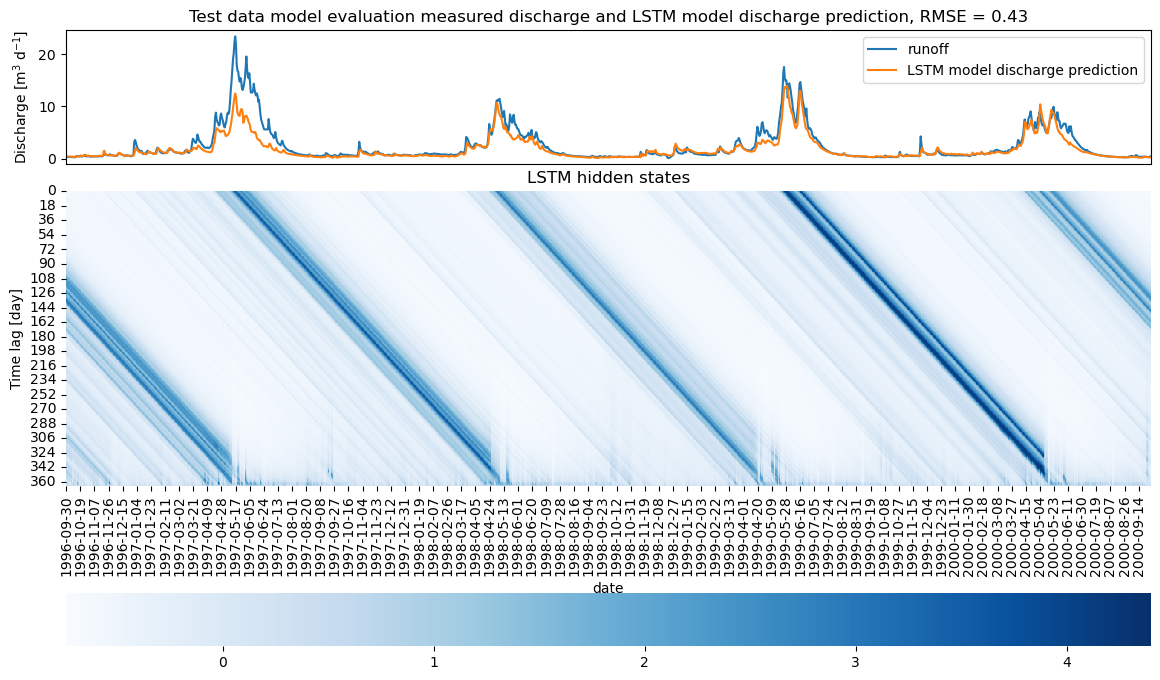

In [32]:
# Test period
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig,hspace=0.5)
ax1 = fig.add_subplot(gs[2:-2,:])
ax2, ax3 = fig.add_subplot(gs[-1,:]), fig.add_subplot(gs[:2,:])

ax1=sns.heatmap(
    df_test_h.T, cmap='Blues', ax=ax1, cbar_ax=ax2, 
    cbar_kws={'orientation':'horizontal', 'fraction':'0.07', 'anchor':(1,-0.5)}
)
ax1.set(title='LSTM hidden states', ylabel='Time lag [day]')
df_test_out.plot(ax=ax3)
ax3.set(ylabel='Discharge [m$^3$ d$^{-1}$]', xlabel='', xlim=ax1.get_xlim(), xticks=[],
        title=f'Test data model evaluation measured discharge and LSTM model discharge prediction, RMSE = {RMSE_train:.2}');
